In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 25
CLASS_COUNT = 4

In [3]:
####    11 var    ####

x1 = [3 + np.random.uniform(0, 0.5) for i in range(N)]
y1 = [0 + np.random.uniform(0, 0.5) for i in range(N)]

x2 = [-3 + np.random.uniform(0, 0.5) for i in range(N)]
y2 = [0 + np.random.uniform(0, 0.5) for i in range(N)]

x3 = [0 + np.random.uniform(0, 0.5) for i in range(N)]
y3 = [3 + np.random.uniform(0, 0.5) for i in range(N)]

x4 = [0 + np.random.uniform(0, 0.5) for i in range(N)]
y4 = [-3 + np.random.uniform(0, 0.5) for i in range(N)]

In [4]:
####    17 var    ####

x1 = [3 + np.random.uniform(0, 0.5) for i in range(N)]
y1 = [0 + np.random.uniform(0, 0.5) for i in range(N)]

x2 = [-3 + np.random.uniform(0, 0.5) for i in range(N)]
y2 = [0 + np.random.uniform(0, 0.5) for i in range(N)]

x3 = [0 + np.random.uniform(0, 0.5) for i in range(N)]
y3 = [3 + np.random.uniform(0, 0.5) for i in range(N)]

x4 = [0 + np.random.uniform(0, 0.5) for i in range(N)]
y4 = [-3 + np.random.uniform(0, 0.5) for i in range(N)]

In [5]:
####    22 var    ####

x1 = [4 + np.random.uniform(0, 0.5) for i in range(N)]
y1 = [0 + np.random.uniform(0, 0.5) for i in range(N)]

x2 = [-4 + np.random.uniform(0, 0.5) for i in range(N)]
y2 = [0 + np.random.uniform(0, 0.5) for i in range(N)]

x3 = [0 + np.random.uniform(0, 0.5) for i in range(N)]
y3 = [4 + np.random.uniform(0, 0.5) for i in range(N)]

x4 = [0 + np.random.uniform(0, 0.5) for i in range(N)]
y4 = [-4 + np.random.uniform(0, 0.5) for i in range(N)]

In [6]:
x = x1 + x2 + x3 + x4
y = y1 + y2 + y3 + y4
Z = np.array([x,y]).T

T = np.array([])
for cl in range(CLASS_COUNT):
    T = np.concatenate((T, np.array([cl for i in range(N)])))
    pass
T = T[:100]

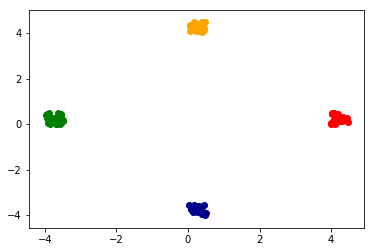

In [7]:
colors = ("red", "green", "orange", "darkblue")
figure = plt.figure()
subplt = figure.add_subplot(1, 1, 1)

for cl in range(CLASS_COUNT):
    step = cl * N
    for i in range(N):
        locX, locY = Z[i + step]
        subplt.scatter(locX, locY, c=colors[cl])
        pass
    pass


plt.show()

In [8]:
class NeuralNetwork:
    
    #### CLASS METHODS ---- ####
    
    def __init__(self, dimensions, activation_functions):
        self.layer_num = len(dimensions)
        assert len(activation_functions) == self.layer_num - 1, "Invalid number of layers"
        self.dimensions = dimensions
        
        self.activation_dictionary = {
            "sigmoid": (lambda x: self.sigmoid(x), lambda x: self.d_sigmoid(x)),
            "tanh": (lambda x: self.tanh(x), lambda x: self.d_tanh(x)),
        }
        self.activation_functions = list(map(lambda x: self.activation_dictionary[x], activation_functions))
        
        self.params = {}
        self.cache = {}
        self.loss = []
        self.epoch_loss = []
        
        self.initLayers()
        pass

    
    def initLayers(self):
        np.random.seed(1)
        for layer in range(1, self.layer_num):
            self.params[f"W{layer}"] = \
                np.random.randn(self.dimensions[layer], self.dimensions[layer-1]) / np.sqrt(self.dimensions[layer-1])
            self.params[f"b{layer}"] = np.zeros((self.dimensions[layer], 1)).T
            pass
        self.logLargeMessage(f"Parameters initialization finished\n{self.params}\n")
        pass
    
    
    def forward(self, z, t=None, loss_calc=True):
        Ziter = z
        for layer in range(1, self.layer_num):
            Z = self.params[f"W{layer}"].dot(Ziter) + self.params[f"b{layer}"]
            A = self.activation_functions[layer-1][0](Z)
            Ziter = A.reshape(A.shape[1])
            
            self.cache[f"Z{layer}"], self.cache[f"A{layer}"] = Z, A
            pass
        output = self.cache[f"A{self.layer_num-1}"]
        if loss_calc == True:
            loss = self.nloss(output, t)
            return output, loss
        else:
            return output
    
    
    def backward(self, z, t, output):
        d_lossYh = self.d_nloss(output, t)
        current_output_loss = d_lossYh
        
        for layer in range(self.layer_num-1, 0, -1):
            d_lossZ = current_output_loss * self.activation_functions[layer-1][1](self.cache[f"Z{layer}"])
            d_lossA = np.dot(self.params[f"W{layer}"].T, d_lossZ.T)
            current_output_loss = d_lossA.T
            
            if layer > 1:
                d_lossW = np.dot(d_lossZ.T, self.cache[f"A{layer-1}"])
                d_lossB = np.dot(d_lossZ, np.ones([d_lossZ.shape[1], 1]))
                self.params[f"W{layer}"] = self.params[f"W{layer}"] - self.learning_rate * d_lossW
                self.params[f"b{layer}"] = self.params[f"b{layer}"] - self.learning_rate * d_lossB
                pass
            else:
                d_lossW = np.dot(d_lossZ.T, z.reshape((1, 2)))
                d_lossB = np.dot(d_lossZ, np.ones([d_lossZ.shape[1], 1]))
                self.params[f"W{layer}"] = self.params[f"W{layer}"] - self.learning_rate * d_lossW
                self.params[f"b{layer}"] = self.params[f"b{layer}"] - self.learning_rate * d_lossB
                pass
            pass
        
        pass
    
    
    def train(self, z, t, learning_rate, epochs):
        self.Z_train, self.T_train, self.Z_valid, self.T_valid = self.prepareTrainingData(z, t)
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        self.logMessage(f"Training using epochs={epochs} and learning_rate={learning_rate} has started")
        for epoch in range(epochs):
            loss = 0.
            for i in range(self.Z_train.shape[1]):
                output, loss = self.forward(self.Z_train[:,i], self.T_train[:,i])
                self.backward(self.Z_train[:,i], self.T_train[:,i], output)
                self.loss.append(loss)
                pass
            self.epoch_loss.append(loss)
            self.logMessage(f"Loss after epoch {epoch}: {loss}")
            pass
        self.logMessage("Training has finished")
        
        self.logMessage("Validation start")
        comp = np.zeros((CLASS_COUNT, self.Z_valid.shape[1]))
        for i in range(self.Z_valid.shape[1]):
            output, loss = self.forward(self.Z_valid[:,i], self.T_valid[:,i])
            max_index = self.maxValueIndex(output)
            comp[max_index, i] = 1
            
            self.logMessage(
                f"X: {np.round(self.Z_valid[:,i], self.DECIMAL_UNITS)} - Yh {np.round(output[0],self.DECIMAL_UNITS)} - Cl {comp[:,i]} - T {self.T_valid[:,i]}")
            pass
        self.logMessage(
            f"Validation data prediction acc: {(self.identicalValuesCount(comp, self.T_valid)/self.T_valid.shape[0])/self.Z_valid.shape[1]}")
        self.logMessage("Validation end")        
        pass
    
    
    def classify(self, z):
        self.logLargeMessage(f"Started classifying objects:\n{z}\n")
        Zclass = self.prepareClassificationData(z)
        classes = np.empty(Zclass.shape[1])
        for i in range(Zclass.shape[1]):
            output = self.forward(Zclass[:,i], loss_calc=False)
            max_index = self.maxValueIndex(output)
            classes[i] = max_index
            self.logMessage(f"Classification. Object: {z[i,:]} --- Class: {max_index}")
            pass
        self.logMessage("Classification has finished")
        return classes
    
    #### ---- CLASS METHODS ####
    
    
    #### FUNCTIONS AND DERIVATIVES ---- ####    
    
    def sigmoid(self, Z):
        return 1./(1 + np.exp(-Z))
    
    
    def d_sigmoid(self, Z):
        S = 1./(1 + np.exp(-Z))
        dZ = S * (1 - S)
        return dZ

    
    def tanh(self, Z):
        return (np.exp(Z)-np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    
    
    def d_tanh(self, Z):
        return 1 - self.tanh(Z)**2
    
    
    def minMaxNorm(self, Z):
        Zresult = np.empty_like(Z)
        for i in range(Z.shape[1]):
            minimum = np.min(Z[:,i])
            maximum = np.max(Z[:,i])
            Zresult[:,i] = np.divide((Z[:,i] - minimum), (maximum - minimum))
            pass
        return Zresult
    
    
    def nloss(self, Yh, t):
        return -np.dot(t, np.log(Yh).T) - np.dot(1-t, np.log(1-Yh).T)
    
    
    def d_nloss(self, Yh, t):
        return -np.divide(t, Yh) + np.divide(1-t, 1-Yh)
    
    #### ---- FUNCTIONS AND DERIVATIVES ####
    
    
    #### HELPER METHODS ---- ####
    
    VALIDATION_PART = 0.2
    DECIMAL_UNITS = 3
    INFO_REQUIRED = True
    LARGE_INFO_REQUIRED = True    
    
    
    def prepareTrainingData(self, z, t):
        self.logLargeMessage(f"Z:\n{z}\n\nT:\n{t}\n")
        
        Znorm = self.minMaxNorm(z)
        Tnorm = np.array(list(map(self.tMapper, t))).reshape(len(Znorm), CLASS_COUNT)
        self.logLargeMessage(f"Znorm:\n{Znorm}\n\nTnorm:\n{Tnorm}\n")
        
        shuff = np.concatenate((Znorm, Tnorm), axis=1)
        np.random.shuffle(shuff)
        
        validation_num = int(len(Tnorm) * self.VALIDATION_PART)
        training_num = int(len(Tnorm) - validation_num)
        self.logMessage(f"Training number: {training_num} Validation number: {validation_num}")
        
        shuffTrain = shuff[0:training_num]
        shuffValid = shuff[training_num:]
        
        Ztrain = shuffTrain[:,(0,1)].T
        Ttrain = shuffTrain[:,2:].T
        
        Zvalid = shuffValid[:,(0,1)].T
        Tvalid = shuffValid[:,2:].T
        
        self.logLargeMessage(f"Ztrain:\n{Ztrain}\n\nTtrain:\n{Ttrain}\n")
        self.logLargeMessage(f"Zvalid:\n{Zvalid}\n\nTvalid:\n{Tvalid}\n")
        return Ztrain, Ttrain, Zvalid, Tvalid
    
    
    def prepareClassificationData(self, z):
        Zclass = self.minMaxNorm(z).T
        self.logLargeMessage(f"Zclass:\n{Zclass}\n")
        return Zclass
    
    
    def tMapper(self, x):
        arr = np.zeros(CLASS_COUNT)
        arr[int(x)] = 1
        return arr
    
    
    def reluMapper(self, x):
        if x <= 0:
            return 0
        else:
            return 1
        
        
    def maxValueIndex(self, Z):
        maxValue = Z[0,0]
        index = 0
        for i in range(1, Z.shape[1]):
            if maxValue < Z[0,i]:
                maxValue = Z[0,i]
                index = i
                pass
            pass
        return index
    
    
    def identicalValuesCount(self, X, Z):
        counter = 0
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                if X[i,j] == Z[i,j]:
                    counter += 1
                    pass
                pass
            pass
        return counter
    
    
    def logMessage(self, msg):
        if self.INFO_REQUIRED == True:
            print(msg)
            pass
        pass
    
    
    def logLargeMessage(self, lmsg):
        if self.LARGE_INFO_REQUIRED == True:
            print(f"----------\n{lmsg}----------\n")
            pass
        pass
    
    #### ---- HELPER METHODS ####
    
    pass

In [9]:
neuralNetwork = NeuralNetwork([2, 10, CLASS_COUNT], ("tanh", "sigmoid"))
neuralNetwork.train(Z, T, learning_rate=0.5, epochs=10)

----------
Parameters initialization finished
{'W1': array([[ 1.14858562, -0.43257711],
       [-0.37347383, -0.75870339],
       [ 0.6119356 , -1.62743362],
       [ 1.23376823, -0.53825456],
       [ 0.22559471, -0.17633148],
       [ 1.03386644, -1.45673947],
       [-0.22798339, -0.27156744],
       [ 0.80169606, -0.77774057],
       [-0.12192515, -0.62073964],
       [ 0.02984963,  0.41211259]]), 'b1': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'W2': array([[-0.34804634,  0.36199342,  0.28510802,  0.15890266,  0.28487566,
        -0.21621373, -0.0388613 , -0.29591628, -0.08471365,  0.16771312],
       [-0.21872233, -0.12546448, -0.21730309, -0.26727749, -0.21226666,
        -0.0040049 , -0.35332456,  0.07412875,  0.52487553,  0.23465497],
       [-0.06066373, -0.28069292, -0.2362722 ,  0.53520114,  0.01606682,
        -0.20143571,  0.06037278,  0.66415899,  0.0379976 ,  0.19517676],
       [ 0.09492219, -0.11139118, -0.36129598, -0.11047187, -0.06605816,
         0.1855065

In [10]:
pointsToClassify = np.array([[0.3,2.6],[0.3,-1.3],[2.3,0.5],[-1.6,0.5]])
classes = neuralNetwork.classify(pointsToClassify)

----------
Started classifying objects:
[[ 0.3  2.6]
 [ 0.3 -1.3]
 [ 2.3  0.5]
 [-1.6  0.5]]
----------

----------
Zclass:
[[0.48717949 0.48717949 1.         0.        ]
 [1.         0.         0.46153846 0.46153846]]
----------

Classification. Object: [0.3 2.6] --- Class: 2
Classification. Object: [ 0.3 -1.3] --- Class: 3
Classification. Object: [2.3 0.5] --- Class: 0
Classification. Object: [-1.6  0.5] --- Class: 1
Classification has finished


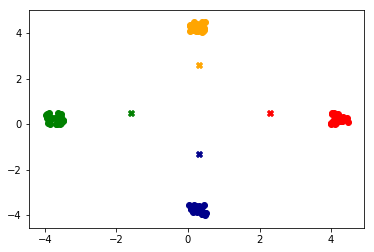

In [11]:
figure = plt.figure()
subplt = figure.add_subplot(1, 1, 1)

for cl in range(CLASS_COUNT):
    step = cl * N
    for i in range(N):
        locX, locY = Z[i + step]
        subplt.scatter(locX, locY, c=colors[cl])
        pass
    pass

for i in range(len(pointsToClassify)):
    locX, locY = pointsToClassify[i]
    subplt.scatter(locX, locY, c=colors[int(classes[i])], marker='X')
    pass

plt.show()

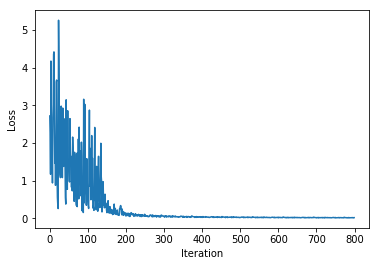

In [12]:
plt.plot(neuralNetwork.loss)
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

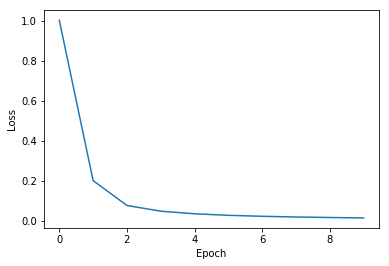

In [13]:
plt.plot(neuralNetwork.epoch_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()